In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv(r"C:\Users\annab\OneDrive\Documentos\GitHub\Colabs\bases\data_prema.csv")

# Processamento

In [2]:
df = df.drop(['RACACOR','CODOCUPMAE','ESCMAE', 'ESCMAE2010',
              'SERIESCMAE','SEMAGESTAC','IDADEPAI', 'DTNASCMAE',
              'STDNEPIDEM', 'STDNNOVA','TPAPRESENT', 'STTRABPART',
              'TPMETESTIM','IDANOMAL', 'CODANOMAL', 'CODESTAB',
              'CODMUNNASC', 'LOCNASC', 'CODMUNRES', 'DTNASC',
              'HORANASC','PARTO', 'PESO', 'APGAR1', 'APGAR5',
              'DTCADASTRO', 'NUMEROLOTE', 'VERSAOSIST', 'DTRECEBIM',
              'DIFDATA', 'DTRECORIGA', 'NATURALMAE', 'CODMUNNATU',
              'CODUFNATU', 'DTULTMENST', 'CONSPRENAT', 'STCESPARTO',
              'TPNASCASSI', 'TPFUNCRESP', 'TPDOCRESP', 'DTDECLARAC',
              'CODPAISRES', 'TPROBSON', 'KOTELCHUCK', 'CONTADOR', 'ORIGEM'], axis=1)

In [3]:
df = df [(df['QTDFILVIVO'] < 12)]
df = df [(df['QTDFILMORT'] < 8)]
df = df[(df['IDADEMAE'] < 54)]

In [4]:
faixas_etarias = [0, 19, 24, 29, 34, 54]
rotulos_etarias = ['0-19', '20-24', '25-29', '30-34', '35-54']
df['FAIXA_ETARIA'] = pd.cut(df['IDADEMAE'], bins=faixas_etarias, labels=rotulos_etarias, right=False)
mapeamento_faixa_etaria = {'0-19': 0, '20-24': 1, '25-29': 2, '30-34': 3, '35-54': 4}
df['FAIXA_ETARIA_INT'] = df['FAIXA_ETARIA'].map(mapeamento_faixa_etaria)

df = df.drop(['FAIXA_ETARIA', 'IDADEMAE'], axis= 1)
df = df.dropna()

In [5]:
df_prema = df[df['GESTACAO'] <= 4].copy()
df_normal = df[df['GESTACAO'] > 4].copy()

df_prema['CLASSE'] = 1
df_normal['CLASSE'] = 0

In [6]:
df = df.drop(columns = ['GESTACAO'])

In [7]:
n_samples = len(df_prema)
df_normal_new = df_normal.sample(n=n_samples, random_state=42)

print("Tamanho de df_prema:", len(df_prema))
print("Tamanho de df_normal (após undersampling):", len(df_normal_new))

Tamanho de df_prema: 54706
Tamanho de df_normal (após undersampling): 54706


In [8]:
df_unificado = pd.concat([df_prema, df_normal_new], ignore_index=True)
df_unificado = df_unificado.drop(columns = ['GESTACAO'])

# Modelo

Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.61      0.75      0.67     16247
           1       0.68      0.54      0.60     16577

    accuracy                           0.64     32824
   macro avg       0.65      0.64      0.64     32824
weighted avg       0.65      0.64      0.64     32824



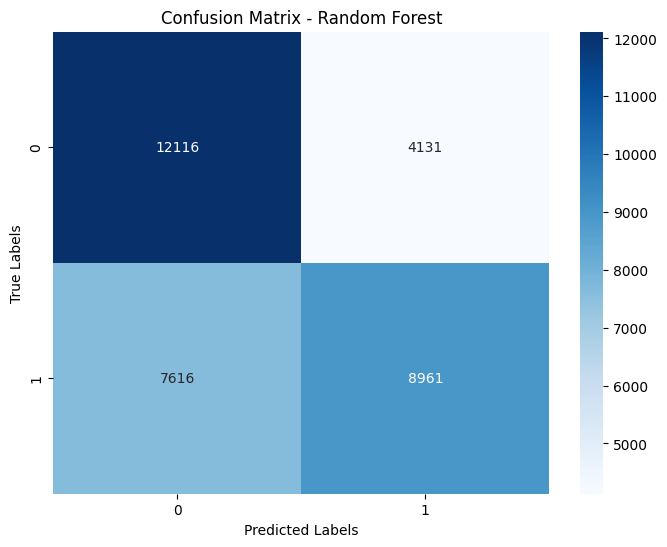

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X = df_unificado.drop('CLASSE', axis=1)
y = df_unificado['CLASSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid_rf = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Melhores parâmetros encontrados:", best_params_rf)

best_rf_model = RandomForestClassifier(random_state=42, **best_params_rf)
best_rf_model.fit(X_train, y_train)

y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap="Blues",
            xticklabels=best_rf_model.classes_,
            yticklabels=best_rf_model.classes_,
            cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Acurácia

Melhor Threshold Calculado: 0.5214
Melhor Acurácia Correspondente: 0.6427


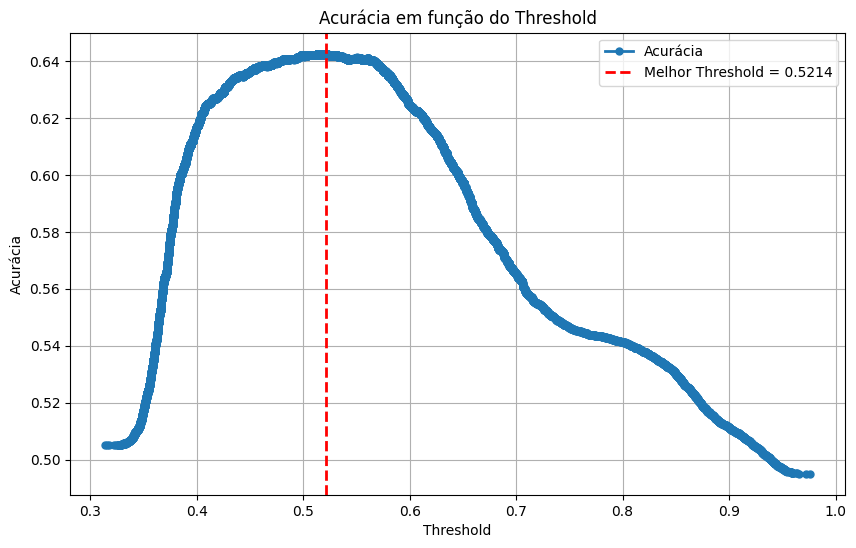

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Definindo um intervalo menor para os thresholds
intervalo = 1  # Pegar todos os valores possíveis para suavizar o gráfico

# Obter as probabilidades de previsão
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]
unique_thresholds = np.sort(np.unique(y_prob_rf))

# Selecionar thresholds de acordo com o intervalo
selected_thresholds = unique_thresholds[::intervalo]

accuracies = []

# Calcular acurácia para cada threshold selecionado
for threshold in selected_thresholds:
    y_pred_threshold = (y_prob_rf >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_threshold)
    accuracies.append(acc)

# Encontrar o melhor threshold
best_threshold_index = np.argmax(accuracies)
best_threshold = selected_thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

# Imprimir o melhor threshold e a melhor acurácia
print(f"Melhor Threshold Calculado: {best_threshold:.4f}")
print(f"Melhor Acurácia Correspondente: {best_accuracy:.4f}")

# Plotar acurácia em função dos thresholds selecionados
plt.figure(figsize=(10, 6))
plt.plot(selected_thresholds, accuracies, marker='o', linestyle='-', linewidth=2, markersize=5, label='Acurácia')
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f"Melhor Threshold = {best_threshold:.4f}")
plt.xlabel('Threshold')
plt.ylabel('Acurácia')
plt.title('Acurácia em função do Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supondo que 'best_rf_model' e 'X_test', 'y_test' estão definidos em seu ambiente
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]
unique_thresholds = np.sort(np.unique(y_prob_rf))

accuracies = []

for threshold in unique_thresholds:
    y_pred_threshold = (y_prob_rf >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_threshold)
    accuracies.append(acc)

best_threshold_index = np.argmax(accuracies)
best_threshold = unique_thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

print(f"Melhor Threshold Calculado: {best_threshold:.4f}")
print(f"Melhor Acurácia Correspondente: {best_accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(unique_thresholds, accuracies, linewidth=1.5, label='Acurácia')
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=1.5, label=f"Melhor Threshold = {best_threshold:.4f}")
plt.xlabel('Threshold')
plt.ylabel('Acurácia')
plt.title('Acurácia em função do Threshold')
plt.legend()
plt.grid()
plt.show()
